# Check values at mismatched QARTOD flags against suspect range thresholds

In [24]:
# Import required libraries
import xarray as xr
import glob
import os
import re
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [3]:
# Import local project functions
from qartod_testing.local_qc_test import load_climatology_qartod_test_values

In [4]:
# Set reference designator, data stream, and method 
method = "recovered_inst"                       
stream = "ctdbp_cdef_instrument_recovered"   
refdes = "CP01CNSM-RID27-03-CTDBPC000"              

In [5]:
# build path to folder where data was saved
folder_path = os.path.join(os.path.abspath('../data/processed'), method, stream, refdes)

# retrieve file name for mismatched flags in this directory
local_files = glob.glob(folder_path+'/*climatology_test_comparison*.nc') # need to change this tag if files exist for more than one parameter
local_files.sort()
# local_files

In [6]:
# load CSV data into pandas DataFrame
file = local_files[0]
mismatch_results = xr.load_dataset(file)
mismatch_results

<xarray.Dataset>
Dimensions:          (time: 6297)
Coordinates:
  * time             (time) datetime64[ns] 2015-12-04T10:31:50 ... 2016-04-01...
Data variables:
    expected_flags   (time) object '3' '3' '3' '3' '3' ... '3' '3' '3' '3' '3'
    local_flags      (time) uint8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    expected_values  (time) float64 14.89 14.89 14.89 ... 11.27 11.27 11.27
Attributes:
    parameter_name:      sea_water_temperature
    ooinet_name:         ctdbp_seawater_temperature
    percent_mismatched:  2%
    file_name:           /home/jovyan/code/qartod_testing/data/external/recov...

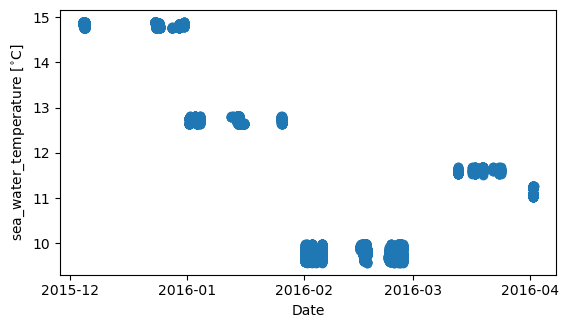

In [7]:
# create figure with scatter plot of expected sea water temperature values
ax = plt.subplot(111,aspect=12)
plt.scatter(mismatch_results['time'], mismatch_results['expected_values'])
plt.ylabel(mismatch_results.parameter_name+' [$^{\circ}$C]')
plt.xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())

Since the saved comparison dataset only contains datetime, flag values that didn't match up, original data points and original data file name, we will also have to import the climatology test threshold values so that we can plot these together

In [8]:
# import threshold values for climatology test
# refdes is already defined but we still need to define the parameter
param = mismatch_results.ooinet_name
thresholds = load_climatology_qartod_test_values(refdes, param)
thresholds['[1, 1]'][0]

[5.9399, 12.8153]

The QARTOD climatology test suspect thesholds change with month, so we will need to plot these values as horizontal lines over a single month 

In [9]:
dec = mismatch_results['time'].sel(time=slice('2015-12','2015-12'))
jan = mismatch_results['time'].sel(time=slice('2016-01','2016-01'))
feb = mismatch_results['time'].sel(time=slice('2016-02','2016-02'))
mar = mismatch_results['time'].sel(time=slice('2016-03','2016-03'))
apr = mismatch_results['time'].sel(time=slice('2016-04','2016-04'))

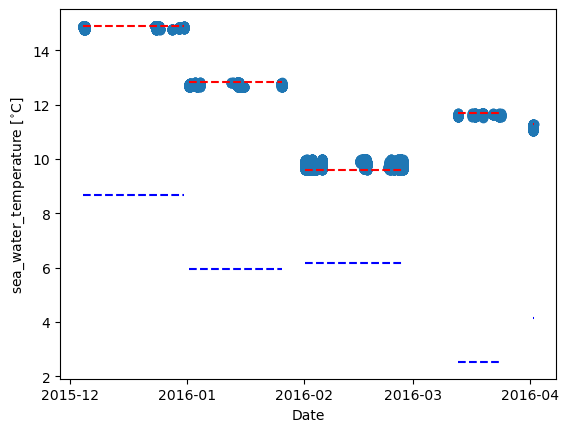

In [10]:
# create figure with horizontal lines showing climatology test monthly thresholds
ax = plt.subplot(111)
plt.scatter(mismatch_results['time'], mismatch_results['expected_values'])
plt.hlines(thresholds['[1, 1]'][0], jan[0], jan[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[2, 2]'][0], feb[0], feb[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[3, 3]'][0], mar[0], mar[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[4, 4]'][0], apr[0], apr[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[12, 12]'][0], dec[0], dec[-1], colors=['blue','red'], linestyles='dashed')
plt.ylabel(mismatch_results.parameter_name+' [$^{\circ}$C]')
plt.xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())



Text(0.5, 0, 'Expected QARTOD flags')

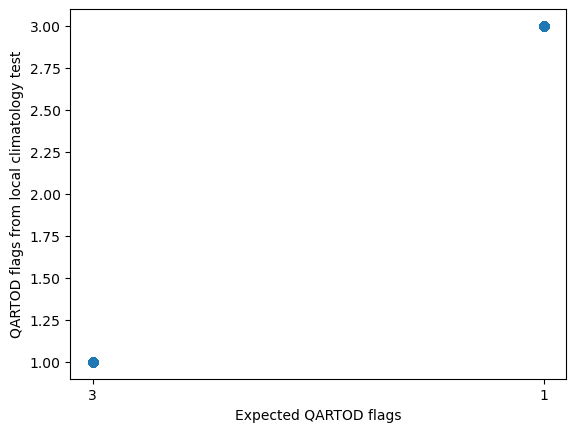

In [41]:
# scatter plot of expected flags v local flags (potential correlation?)
ax = plt.subplot(111)
plt.scatter(mismatch_results['expected_flags'], mismatch_results['local_flags'])
plt.ylabel('QARTOD flags from local climatology test')
plt.xlabel('Expected QARTOD flags')

So the plot above is not that interesting; it just seems to show that the local and expected flags disagree on which points should be 'good' and which are 'suspect'. At least I know that none of the conflicting flags are 9's, 4's or 2's.

/tmp/ipykernel_261/2946248474.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(211)


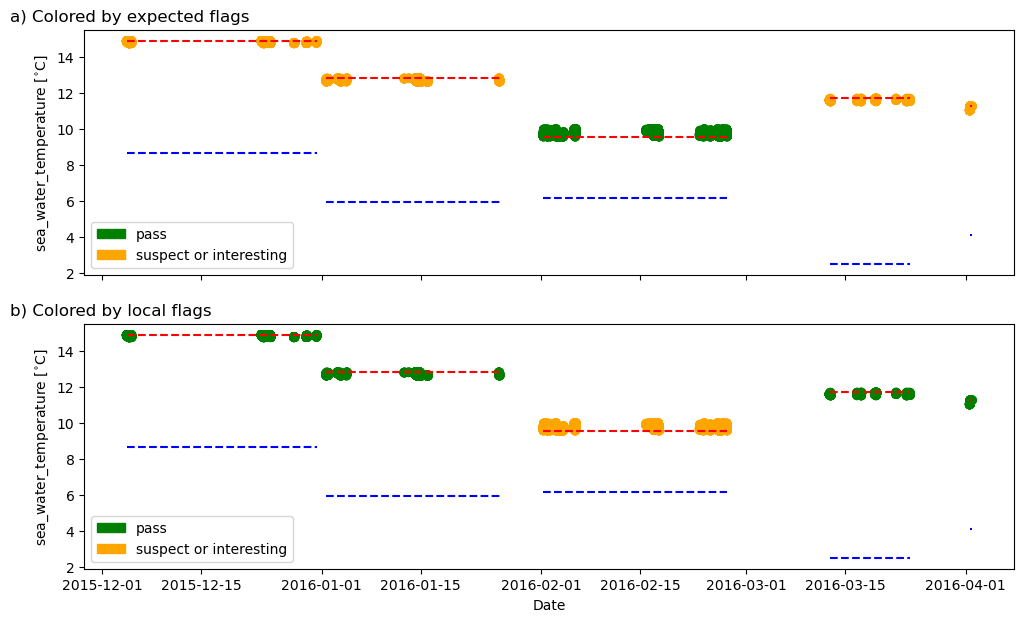

In [39]:
# Same plot with temperature values and test thresholds as above but two plots: one with color
# of the points determined by local flags and one where color of points is determined by 
# expected flags.
fig = plt.subplots(figsize=(12,7))
green_patch = mpatches.Patch(color='green', label='pass')
orange_patch = mpatches.Patch(color='orange', label='suspect or interesting')

ax1 = plt.subplot(211)
scatter1 = plt.scatter(mismatch_results['time'], mismatch_results['expected_values'], c=mismatch_results['expected_flags'], cmap=ListedColormap(['green', 'orange']))
plt.hlines(thresholds['[1, 1]'][0], jan[0], jan[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[2, 2]'][0], feb[0], feb[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[3, 3]'][0], mar[0], mar[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[4, 4]'][0], apr[0], apr[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[12, 12]'][0], dec[0], dec[-1], colors=['blue','red'], linestyles='dashed')
plt.ylabel(mismatch_results.parameter_name+' [$^{\circ}$C]')
plt.title('a) Colored by expected flags', loc='left', x=-0.08)
plt.tick_params('x', labelbottom=False)
ax1.legend(handles=[green_patch, orange_patch], loc='lower left')

ax2 = plt.subplot(212, sharex=ax1)
plt.scatter(mismatch_results['time'], mismatch_results['expected_values'], c=mismatch_results['local_flags'], cmap=ListedColormap(['green', 'orange']))
plt.hlines(thresholds['[1, 1]'][0], jan[0], jan[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[2, 2]'][0], feb[0], feb[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[3, 3]'][0], mar[0], mar[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[4, 4]'][0], apr[0], apr[-1], colors=['blue','red'], linestyles='dashed')
plt.hlines(thresholds['[12, 12]'][0], dec[0], dec[-1], colors=['blue','red'], linestyles='dashed')
plt.ylabel(mismatch_results.parameter_name+' [$^{\circ}$C]')
plt.xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('b) Colored by local flags', loc='left', x=-0.08)
ax2.legend(handles=[green_patch, orange_patch], loc='lower left')

I forgot how to not have the top x-axis have numbers and need to move on to something else for now, so next: clean up the plot above, while thinking about what it could mean and questions to ask Andrew 